Done!
Q =  107.746344767  W
Tr =  17.3622379208  C
Ta =  -20.637584734  C
Fbi =  11.999999999999998  %
Sg =  0.08631027910211064  W/K
eff =  34.1489436614  %


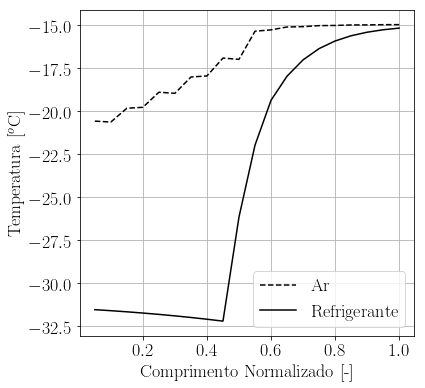

In [1]:
import numpy as np
import math
from CoolProp.CoolProp import PropsSI as prop
import matplotlib.pyplot as plt
#############################################
### Correlations and functions definition ###
#############################################

def f_chur(Re,D):
    
    rug = 0#0.0046e-2 #Rugosidade para o alumínio em m
    A = (2.457*np.log(1/((7/Re)**0.9+0.27*(rug/D))))**16
    B = (37530/Re)**16
    parameter = 8*((8/Re)**12 + (A+B)**(-3/2))**(1/12)

    return(parameter)

def Xtt(x,G,D,f_l,rho_l,f_v,rho_v):
    
    dpdz_l = 2*f_l*G**2*(1-x)**2/(D*rho_l)
    dpdz_v = 2*f_v*G**2*x**2/(D*rho_v)
    parameter = math.sqrt(dpdz_l/dpdz_v)
    
    return(parameter)


def  eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,D):
    
    Nu_lo = Re_lo**(4/5)*Pr_lo**0.4
    eta_lo = Nu_lo*k_lo/D
    parameter = eta_lo*3.3775*xtt**-0.6285
    
    return(parameter)

def  eta_mono(Re,Pr,k,D):
    
    Nu = 0.023*Re**(4/5)*Pr**(1/3) 
    parameter = Nu*k/D

    return(parameter)

def eta_air(Re_air,Pr_air,G_air,cp_air,Ap,Af,A_tonly):
    
    eps= (A_tonly+Af)/A_tonly#(Ap+Af)/Ap#
    j = 0.138*Re_air**(-0.281)*eps**(-0.407)
    St = j*Pr_air**(-2/3)
    parameter = St*G_air*cp_air
    
    return(parameter)

def surf_eff(Ap,Af,D_in,delta,eta_ar,k_al,x_t,x_l):
    
    r=D_in/2
    M=x_t/2
    L=math.sqrt((x_t/2)**2+x_l**2)    
    phi=L/M
    psi=M/r
    R_eq = r*1.27*psi*(phi-0.3)**(1/2)
    
    m=math.sqrt(2*eta_ar/(k_al*delta))
    var_phi = (R_eq/r -1)*(1+0.35*np.log(R_eq/r))
    eff_fin=np.tanh(m*r*var_phi)/(m*r*var_phi)
    parameter = 1-(1-eff_fin)*(Af/(Ap+Af))
    #print(m,phi,psi,var_phi,eff_fin,parameter)
    
    return(parameter)
    
def epsilon(C_ar,C_r134a,NTU,quality_r134a,q_lim):
    
    if quality_r134a < q_lim:
        
        parameter = 1 - np.exp(-NTU)
    
    elif quality_r134a >= q_lim: 
        
        if C_ar >= C_r134a:
        
            c = C_r134a/C_ar
            #parameter = 1 - np.exp( NTU**0.22/c*(np.exp(-c*NTU**0.78) -1 ))
            parameter = 1 - np.exp(-(1/c)*(1-np.exp(-c*NTU)))

            
        if C_ar < C_r134a:
            
            c = C_ar/C_r134a
            #parameter = 1 - np.exp( NTU**0.22/c*(np.exp(-c*NTU**0.78) -1 ))
            parameter = (1/c)*(1-np.exp(1-c*(1-np.exp(-NTU))))
    
    return(parameter)

###############################
### Equações de conservação ###
###############################

def movimento(Pin,W,Di,G,v,mu_l):
    
    Re = G*Di/mu_l
    f = f_chur(Re,Di)/4
    tau = f*G**2*v/2
    parameter = Pin - tau*np.pi*W*4/(np.pi*Di)
    
    return(parameter)

def energia_bi(hin,Pin,Pavg,Qavg,mfrin,Tain,Taavg,Pa,mfra,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl,Do,A_ton,A_face,qlim):
    
    mu_l =prop('V','P',Pavg,'Q',0,'R134a')
    mu_v = prop('V','P',Pavg,'Q',1,'R134a')
    rho_l = prop('D','P',Pavg,'Q',0,'R134a')
    rho_v = prop('D','P',Pavg,'Q',1,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    G_l = G*(1-Qavg)
    G_v = G*Qavg
    Re_l = G_l*Di/mu_l
    Re_v = G_v*Di/mu_v
    f_l =f_chur(Re_l,Di)
    f_v =f_chur(Re_v,Di)
    
    xtt = Xtt(Qavg,G,Di,f_l,rho_l,f_v,rho_v)
    Re_lo = G*Di/prop('V','P',Pavg,'Q',0,'R134a')
    Pr_lo = prop('PRANDTL','P',Pavg,'Q',0,'R134a')
    k_lo = prop('L','P',Pavg,'Q',0,'R134a')
    
    etabi=eta_bifasico(Re_lo,xtt,Pr_lo,k_lo,Di)
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('V','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    G_a= mfra/A_face
    Re_a = G_a*Do/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s,A_ton)
     
    eff_surf = surf_eff(A_ton,A_s,Do,deltaf,eta_a,kal,xt,xl)
        
    C_a = (mfra/2)*cp_a
    cp_r=prop('C','P',Pavg,'Q',Qavg,'R134a')
    C_r = mfrin*cp_r
    UA = (1/(etabi*np.pi*Di*W) + 1/(eff_surf*eta_a*A_t))**-1
    Ntu = UA/C_a
    eff = epsilon(C_a,C_r,Ntu,Qavg,qlim)
    
    parameter2 = eff*C_a*(Tain-Tin)
    parameter = hin + parameter2*4/(G*np.pi*Di**2)
    
    return(parameter,parameter2)


def energia_mono(hin,Pin,Pavg,havg,mfrin,Tain,Taavg,Pa,mfra,W,Di,A_c,A_p,A_s,A_t,deltaf,kal,xt,xl,Do,A_ton,A_face,qlim):
    
    mu_v = prop('V','P',Pavg,'H',havg,'R134a')
    rho_v = prop('D','P',Pavg,'H',havg,'R134a')
    Pr_v = prop('PRANDTL','P',Pavg,'H',havg,'R134a')
    k_v = prop('L','P',Pavg,'H',havg,'R134a')
    
    G = mfrin/(np.pi*Di**2/4)
    Re_v = G*Di/mu_v
    f_v =f_chur(Re_v,Di)
   
    etamono=eta_mono(Re_v,Pr_v,k_v,Di)
    Tin = prop('T','P',Pin,'H',hin,'R134a')
    
    rho_a = prop('D','T',Taavg,'P',Pa,'Air')
    mu_a = prop('V','T',Taavg,'P',Pa,'Air')
    Pr_a = prop('PRANDTL','T',Taavg,'P',Pa,'Air')
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    G_a= mfra/A_face
    Re_a = G_a*Do/mu_a
    
    eta_a = eta_air(Re_a,Pr_a,G_a,cp_a,A_p,A_s,A_ton)
    eff_surf = surf_eff(A_ton,A_s,Do,deltaf,eta_a,kal,xt,xl)

    C_a = (mfra/2)*cp_a
    cp_v=prop('C','P',Pavg,'H',havg,'R134a')
    C_v = mfrin*cp_v

    UA = (1/(etamono*np.pi*Di*W) + 1/(eff_surf*eta_a*A_t))**-1
    Ntu = UA/min(C_a,C_v)
    eff = epsilon(C_a,C_v,Ntu,1,qlim)
    
    parameter2 = eff*min(C_a,C_v)*(Tain-Tin)
    parameter = hin + parameter2*4/(G*np.pi*Di**2)
    
    return(parameter,parameter2)


def energia_ar(Tain,Taavg,Pa,mfra,Q_ht):
    
    cp_a = prop('C','T',Taavg,'P',Pa,'Air')
    parameter = Tain - Q_ht/(mfra*cp_a)
    
    return(parameter)

################
### Geometry ###
################

W=300e-3
L = 190e-3
H=60e-3
nt_l = 10
nt_v = 2
delta_f = 0.15e-3
x_t = 11e-3
x_l = 19e-3
D_i = 6.7e-3
D_o=7.9e-3
L_t=W

# Region I

nf_I = 23
nt_I = 6
L_I = 3*x_l
Ap_I = np.pi*D_o*(W-nf_I*delta_f)*nt_I+2*(L_I*H - np.pi*D_o**2/4*nt_I)
As_I = 2*(L_I*H - np.pi*D_o**2/4*nt_I)*(nf_I)+H*delta_f*nf_I
At_I = Ap_I+As_I
A_to_I = np.pi*D_o*(W-nf_I*delta_f)*nt_I

two_a_I = (x_t - D_o) - (x_t-D_o)*delta_f*nf_I/W
b_I = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_I/W

c_I = min(two_a_I,2*b_I)

Ac_I = (H/x_t-1)*c_I*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_I 
Af_I = (W-delta_f*nf_I)*(H)

# Region II

nf_II = 47
nt_II = 4
L_II = 3*x_l
Ap_II = np.pi*D_o*(W-nf_II*delta_f)*nt_II+2*(L_II*H - np.pi*D_o**2/4*nt_II)
As_II = 2*(L_II*H - np.pi*D_o**2/4*nt_II)*(nf_II)
At_II = Ap_II+As_II
A_to_II = np.pi*D_o*(W-nf_II*delta_f)*nt_II

two_a_II = (x_t - D_o) - (x_t-D_o)*delta_f*nf_II/W
b_II = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_II/W

c_II = min(two_a_II,2*b_II)

Ac_II = (H/x_t-1)*c_II*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_II
Af_II = (W-delta_f*nf_II)*(H)

# Region III

nf_III = 47
nt_III = 10
L_III = 4*x_l
Ap_III = np.pi*D_o*(W-nf_III*delta_f)*nt_III+2*(L_III*H - np.pi*D_o**2/4*nt_III)
As_III = 2*(L_III*H - np.pi*D_o**2/4*nt_III)*(nf_III)+H*delta_f*nf_III
At_III = Ap_III+As_III
A_to_III = np.pi*D_o*(W-nf_III*delta_f)*nt_III

two_a_III = (x_t - D_o) - (x_t-D_o)*delta_f*nf_III/W
b_III = ((x_t/2)**2+x_l**2)**(1/2) - D_o - (x_t-D_o)*delta_f*nf_III/W

c_III = min(two_a_III,2*b_III)

Ac_III = (H/x_t-1)*c_III*W+(x_t-D_o)*W -(x_t - D_o)*delta_f*nf_III
Af_III = (W-delta_f*nf_III)*(H)

###############
### Circuit ###
###############

#index function
def j_index(value,jcircuit):
    
    ind_1, ind_2 = np.where(jcircuit == value)

    return(ind_1,ind_2)

#ccorrente e paralelo
'''j_circuit=np.zeros((10,2))

for k in range(2):
  
    for j in range(10):
        
        if k == 0:
            j_circuit[j][k] = 9-j
        else:
            j_circuit[j][k] = 9+1+j'''

# ccorrente

j_circuit=np.zeros((10,2))
  
for j in range(10):

    for k in range(2):
        
        if j % 2 == 0:
            j_circuit[j][0] = (9-j)*(2)+1
            j_circuit[j][1] = (9-j)*(2)
        else:
            j_circuit[j][0] = (9-j)*(2)
            j_circuit[j][1] = (9-j)*(2)+1
            
# paralelo

'''j_circuit=np.zeros((10,2))
  
for j in range(10):

    for k in range(2):
        
        if j % 2 == 0:
            j_circuit[j][0] = (j)*(2)+1
            j_circuit[j][1] = (j)*(2)
        else:
            j_circuit[j][0] = (j)*(2)
            j_circuit[j][1] = (j)*(2)+1'''
##############################
### Inputs and first guess ###
##############################

#Test 1
'''Pr_inlet = 0.779e5
Q_inlet = 0.427
Ta_inlet = -20.7+273.15
mfrr_inlet = 3.2/3600
vfra_inlet = 50.5/3600'''

#Test 2
'''Pr_inlet = 0.795e5
Q_inlet = 0.43
Ta_inlet = -11.4+273.15#
mfrr_inlet = 2.6/3600#2.6/3600
vfra_inlet = 50.8/3600#50.8/3600'''

#Test 3
'''Pr_inlet = 0.785e5
Q_inlet = 0.43
Ta_inlet = -14.8+273.15#
mfrr_inlet = 2.8/3600
vfra_inlet = 49.3/3600'''

#trabalho

Pr_inlet = 0.785e5
Q_inlet = 0.43
Ta_inlet = -15+273.15#
mfrr_inlet = 2.8/3600
vfra_inlet = 50/3600

Tr_inlet = prop('T','P',Pr_inlet,'Q',Q_inlet,'R134a')
hr_inlet = prop('H','P',Pr_inlet,'Q',Q_inlet,'R134a')
hr_outlet = prop('H','P',Pr_inlet,'Q',1,'R134a')
G_r = mfrr_inlet/(np.pi*D_i**2/4)
Pa_inlet = 101325
rhoa_inlet = prop('D','P',Pa_inlet,'T',Ta_inlet,'Air')
mfra_inlet = rhoa_inlet*vfra_inlet
k_al = 203

hr_in = np.linspace(hr_inlet,hr_outlet,20)#np.ones((20))*hr_inlet 
hr_out = np.linspace(hr_inlet,hr_outlet,20)#np.ones((20))*hr_inlet

Tref_in=np.zeros((20))
Tref_out=np.zeros((20))
Pr_in=np.ones((20))*Pr_inlet
Pr_out=np.ones((20))*Pr_inlet
Qr_in=np.ones((20))*Q_inlet
Qr_out=np.ones((20))*Q_inlet
Q_ht_r=np.zeros((20))
eta_r=np.zeros((20))
eta_airside=np.zeros((20))
Ta_in=np.ones((10,2))*(Ta_inlet)
Ta_out=np.ones((10,2))*(Ta_inlet)

hr_out_cycle = np.zeros((20))
Pr_out_cycle = np.zeros((20))
Ta_out_cycle = np.zeros((10,2))
hr_out_cycle_new = np.zeros((20))
Pr_out_cycle_new = np.zeros((20))
Ta_out_cycle_new = np.zeros((10,2))

Ap=np.zeros((10,2))
As=np.zeros((10,2))
At=np.zeros((10,2))
Ac=np.zeros((10,2))
Ato=np.zeros((10,2))
Aface=np.zeros((10,2))

Ap[0:4,:]=Ap_I/nt_I
Ap[4:6,:]=Ap_II/nt_II
Ap[6:10,:]=Ap_III/nt_III

As[0:4,:]=As_I/nt_I
As[4:6,:]=As_II/nt_II
As[6:10,:]=As_III/nt_III

Ac[0:4,:]=Ac_I
Ac[4:6,:]=Ac_II
Ac[6:10,:]=Ac_III

At[0:4,:]=(Ap_I+As_I)/nt_I
At[4:6,:]=(Ap_II+As_II)/nt_II
At[6:10,:]=(Ap_III+As_III)/nt_III

Ato[0:4,:]=A_to_I/nt_I
Ato[4:6,:]=A_to_II/nt_II
Ato[6:10,:]=A_to_III/nt_III

Aface[0:4,:]=Af_I
Aface[4:6,:]=Af_II
Aface[6:10,:]=Af_III

####################
### Main Routine ###
####################

###### Uses inlet conditions #######

tube_it=1
air_it=1
cycle_it=100000000
dry_it = 100000000

alpha_tube_nodryout = 0
alpha_air = 0
alpha_cycle = 0
alpha_dry = 0

Tol_cycle = 1e-4
Tol_air = 1e-4
Tol_tube = 1e-4
tol_dryout = 1e-4

n_dry = 5
q_dry = 1
dry_step = 0.01

T_air_row =[0,0]

for res in range(cycle_it):
    
    hr_out_cycle_old = np.copy(hr_out)
    Pr_out_cycle_old = np.copy(Pr_out)
    Ta_out_cycle_old = np.copy(Ta_out)
    

    ############
    ### Tube ###
    ############
    
    for ind in range(20):

        ind_j,ind_k = j_index(ind,j_circuit)
        Ta_in_tube = Ta_in[int(ind_j),int(ind_k)]
        Ta_out_tube = Ta_out_cycle_old[int(ind_j),int(ind_k)]
        Tr_in = prop('T','P',Pr_in[ind],'H',hr_in[ind],'R134a')        
        Q_in = abs(prop('Q','P',Pr_in[ind],'H',hr_in[ind],'R134a'))
        
        Pr_out_old_it = float(np.copy(Pr_out_cycle_old[ind]))
        hr_out_old_it = float(np.copy(hr_out_cycle_old[ind]))
        Q_out = abs(prop('Q','P',Pr_out_old_it,'H',hr_out_old_it,'R134a'))

        for res in range(tube_it):
            
            Pr_out_old = Pr_out_old_it
            hr_out_old = hr_out_old_it

            rho_r = prop('D','P',Pr_in[ind],'H',hr_in[ind],'R134a')
            v_r = 1/rho_r
            
            if Q_in < q_dry and Q_out < q_dry :
                mu_r = prop('V','P',Pr_in[ind],'Q',0,'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_bi(hr_in[ind],Pr_in[ind],Pr_in[ind],Q_in,mfrr_inlet,Ta_in_tube,Ta_in_tube,Pa_inlet,mfra_inlet,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l,D_o,Ato[ind_j,ind_k],Aface[ind_j,ind_k],q_dry)
                alpha_tube=alpha_tube_nodryout

            
            elif Q_in >= q_dry and Q_out >=q_dry : 
                mu_r = prop('V','P',Pr_in[ind],'H',hr_in[ind],'R134a')
                Pr_out_new = movimento(Pr_in[ind],W,D_i,G_r,v_r,mu_r)
                hr_out_new,Q_ht_r[ind] = energia_mono(hr_in[ind],Pr_in[ind],Pr_in[ind],hr_in[ind],mfrr_inlet,Ta_in_tube,Ta_in_tube,Pa_inlet,mfra_inlet,W,D_i,Ac[ind_j,ind_k],Ap[ind_j,ind_k],As[ind_j,ind_k],At[ind_j,ind_k],delta_f,k_al,x_t,x_l,D_o,Ato[ind_j,ind_k],Aface[ind_j,ind_k],q_dry)
                alpha_tube=alpha_tube_nodryout

                
            elif Q_in < q_dry and Q_out >= q_dry:
                
                
                hr_in_dry = hr_in[ind]
                Pr_in_dry = Pr_in[ind]
                Q_ht_temp = 0
                F_bi = 0
                
                for ind_dry in range(dry_it):
                     
                    F_bi += dry_step    
                    Q_in_dry = abs(prop('Q','P',Pr_in_dry,'H',hr_in_dry,'R134a'))
                    rho_r = prop('D','P',Pr_in_dry,'H',hr_in_dry,'R134a')
                    v_r = 1/rho_r
                    mu_r = prop('V','P',Pr_in_dry,'Q',0,'R134a')
                    Pr_out_dry = movimento(Pr_in_dry,W*F_bi,D_i,G_r,v_r,mu_r)
                    hr_out_dry,Q_ht_r_dry = energia_bi(hr_in_dry,Pr_in_dry,Pr_in_dry,Q_in_dry,mfrr_inlet,Ta_in_tube,Ta_in_tube,Pa_inlet,mfra_inlet*F_bi,W*F_bi,D_i,Ac[ind_j,ind_k]*F_bi,Ap[ind_j,ind_k]*F_bi,As[ind_j,ind_k]*F_bi,At[ind_j,ind_k]*F_bi,delta_f,k_al,x_t,x_l,D_o,Ato[ind_j,ind_k]*F_bi,Aface[ind_j,ind_k]*F_bi,q_dry)
                    Q_ht_temp += Q_ht_r_dry
                    
                    Q_out_dry = abs(prop('Q','P',Pr_out_dry,'H',hr_out_dry,'R134a'))
                                                           
                    if Q_out_dry < q_dry:
                        
                        hr_in_dry = hr_out_dry
                        Pr_in_dry = Pr_out_dry
                                                
                        continue
                        
                    else:
                        
                        F_mono = 1-F_bi
                        mu_r = prop('V','P',Pr_in_dry,'H',hr_out_dry,'R134a')
                        Pr_out_new = movimento(Pr_out_dry,W*F_mono,D_i,G_r,v_r,mu_r)
                        hr_out_new,Q_ht_r_mono = energia_mono(hr_out_dry,Pr_out_dry,Pr_out_dry,hr_out_dry,mfrr_inlet,Ta_in_tube,Ta_in_tube,Pa_inlet,mfra_inlet*F_mono,W*F_mono,D_i,Ac[ind_j,ind_k]*F_mono,Ap[ind_j,ind_k]*F_mono,As[ind_j,ind_k]*F_mono,At[ind_j,ind_k]*F_mono,delta_f,k_al,x_t,x_l,D_o,Ato[ind_j,ind_k]*F_mono,Aface[ind_j,ind_k]*F_mono,q_dry)
                                                
                        break
                
                    
                Q_ht_r[ind] = Q_ht_temp+Q_ht_r_mono
                alpha_tube = alpha_dry               
                                        
            Pr_out_old_it = alpha_tube*Pr_out_old + (1-alpha_tube)*Pr_out_new
            hr_out_old_it = alpha_tube*hr_out_old + (1-alpha_tube)*hr_out_new
            
            res_P_tube = abs(Pr_out_new - Pr_out_old)
            res_h_tube = abs(hr_out_new - hr_out_old)
            
            res_tube =max(res_h_tube,res_P_tube)            

            if res_tube < Tol_tube:
                
                break
            
            else:
                  
                continue
            
        Pr_out_cycle_new[ind]= Pr_out_new
        hr_out_cycle_new[ind]= hr_out_new

    ###########
    ### Air ###
    ###########
    
    for ind2 in range(10):
        
        for ind5 in range(2):
            
            tube_index = j_circuit[ind2,ind5]
            Ta_out_old_it = Ta_out_cycle_old[ind2,ind5]
                             
            for res in range(air_it):

                Ta_out_old = Ta_out_old_it
                Q_ht_air = Q_ht_r[int(tube_index)] 
                Ta_out_new = energia_ar(Ta_in[ind2,ind5],Ta_in[ind2,ind5],Pa_inlet,mfra_inlet/2,Q_ht_air)

                Ta_out_old_it = alpha_air*Ta_out_old + (1-alpha_air)*Ta_out_new
                res_air = abs(Ta_out_new - Ta_out_old)

                if res_air < Tol_air:

                    break

                else:

                    continue

            Ta_out_cycle_new[ind2,ind5] = Ta_out_new
                  
    ###############################################        
    ### Cycle convergency  and sub-relaxatation ###
    ###############################################
    
    res_P_cycle = max(abs(Pr_out_cycle_new - Pr_out_cycle_old)/Pr_out_cycle_old)
    res_h_cycle = max(abs(hr_out_cycle_new - hr_out_cycle_old)/hr_out_cycle_old)
    res_ta_cycle_array = abs(Ta_out_cycle_new - Ta_out_cycle_old) 
    res_Ta_cycle = res_ta_cycle_array.max()
    res_cycle=max(res_h_cycle,res_P_cycle,res_Ta_cycle)
        
    if res_cycle < Tol_cycle:

        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_new[ind3]
            Pr_out[ind3] = Pr_out_cycle_new[ind3]

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):
            
            for ind6 in range(2):

                Ta_out[ind4,ind6] = Ta_out_cycle_new[ind4,ind6]

                if ind4 != 9:
                    
                    Ta_in[ind4+1,ind6]= Ta_out[ind4,ind6]
                
        break
    
    else:
        
        for ind3 in range(20):

            hr_out[ind3] = hr_out_cycle_old[ind3]*alpha_cycle + hr_out_cycle_new[ind3]*(1-alpha_cycle) 
            Pr_out[ind3] = Pr_out_cycle_old[ind3]*alpha_cycle + Pr_out_cycle_new[ind3]*(1-alpha_cycle)

            if ind3 != 19:

                Pr_in[ind3+1]=Pr_out[ind3]
                hr_in[ind3+1]=hr_out[ind3]


        for ind4 in range(10):
            
            for ind6 in range(2):

                Ta_out[ind4,ind6] = Ta_out_cycle_old[ind4,ind6]*alpha_cycle + Ta_out_cycle_new[ind4,ind6]*(1-alpha_cycle)

                if ind4 != 9:
                    
                    Ta_in[ind4+1,ind6]= Ta_out[ind4,ind6]
            
        continue
    
    
for index in range(20):
    
    Qr_out[index] = abs(prop('Q','P',Pr_out[index],'H',hr_out[index],'R134a'))
    Qr_in[index] = abs(prop('Q','P',Pr_in[index],'H',hr_in[index],'R134a'))
    Tref_out[index] = prop('T','P',Pr_out[index],'H',hr_out[index],'R134a')
    Tref_in[index] = prop('T','P',Pr_in[index],'H',hr_in[index],'R134a')

print('Done!')

#########################
### pós-processamento ###
#########################

Tsat=prop('T','P',Pr_out[-1],'Q',0.5,'R134a')
print('Q = ',np.sum(Q_ht_r),' W')
print('Tr = ',Tref_out[-1]-Tsat,' C')
print('Ta = ',np.average(Ta_out[-1])-273.15,' C')
print('Fbi = ',F_bi*100,' %')

sr_in = prop('S','P',Pr_in[0],'H',hr_in[0],'R134a')
sr_out = prop('S','P',Pr_out[-1],'H',hr_out[-1],'R134a')
Sg_r = mfrr_inlet*(sr_out-sr_in)

sa_in = prop('S','P',Pa_inlet,'T',Ta_in[0,0],'Air')
sa_out_1 = prop('S','P',Pa_inlet,'T',Ta_in[-1,0],'Air')
sa_out_2 = prop('S','P',Pa_inlet,'T',Ta_in[-1,1],'Air')
Sg_a = mfra_inlet*((sa_out_1+sa_out_2)/2 - sa_in)

Sg = Sg_r+Sg_a

print('Sg = ',Sg,' W/K')

cp_air=prop('C','P',Pa_inlet,'T',Ta_in[0,0],'Air')


eff = np.sum(Q_ht_r)/(mfra_inlet*cp_air*(Ta_in[0,0] - Tref_in[0]))
print('eff = ',100*eff,' %')

%matplotlib inline
###########################
### plot de temperatura ###
###########################

plt.rc('text',usetex = True)
plt.rc('font', **{'family': 'serif', 'size':18})

x_plot = np.linspace(1/20,1,20)
x_plot = np.round(x_plot,2)
Ta_plot = np.ones((20))
for i in range(10):
    for j in range(2):
        
        Ta_plot[int(j_circuit[i,j])] = Ta_out[i,j]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111)
ax.plot(x_plot,Ta_plot-273.15,'--',color = 'black',label = 'Ar')
ax.plot(x_plot,Tref_out-273.15,'-',color = 'black',label = 'Refrigerante')

ax.set_xlabel('Comprimento Normalizado [-]')
ax.set_ylabel('Temperatura [$^o$C]')
ax.legend(loc = 'lower right')
ax.grid()
           
#fig.savefig('CC.pdf',format = 'pdf', dpi=800,bbox_inches='tight')